特定期間の予測値の総量を知りたい時の95%信頼区間をシミュレーションで求められないか

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.display.float_format = '{:.5f}'.format

,target
0,112
1,118
2,132
3,129
4,121


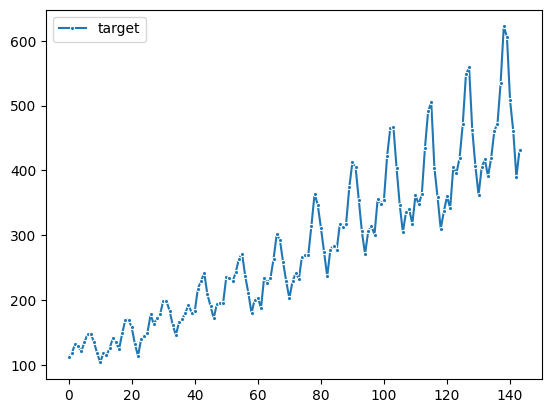

In [2]:
dataset = sm.datasets.get_rdataset('AirPassengers')
df = dataset.data['value'].to_frame(name="target")
display(df.head())

fig, ax = plt.subplots()
sns.lineplot(df, marker='.')
plt.show()

df_train = df.iloc[:-10]
df_test = df.iloc[-10:]

モデリング

In [3]:
# p=1, d=0, q=1, P=1, D=0, Q=1で考える
results = SARIMAX(df_train["target"], order=(1,0,1), seasonal_order=(1,0,1,12),
                            enforce_stationarity = False, enforce_invertibility = False
                           ).fit()

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                  134
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -435.404
Date:                            Sun, 03 Mar 2024   AIC                            880.807
Time:                                    06:19:14   BIC                            894.745
Sample:                                         0   HQIC                           886.467
                                            - 134                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9154      0.052     17.575      0.000       0.813       1.017
ma.L1         -0.2901      0.084     -3.463      0.001      -0.454      -0.126
ar.S.L12       1.1267      0.011    105.153      0.000       1.106       1.148
ma.S.L12      -0.4638      0.114     -4.061      0.000      -0.688      -0.240
sigma2        80.9550     10.266      7.886      0.000      60.835     101.075
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 9.32
Prob(Q):                              0.74   Prob(JB):                         0.01
Heteroskedasticity (H):               1.49   Skew:                            -0.40
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

予測

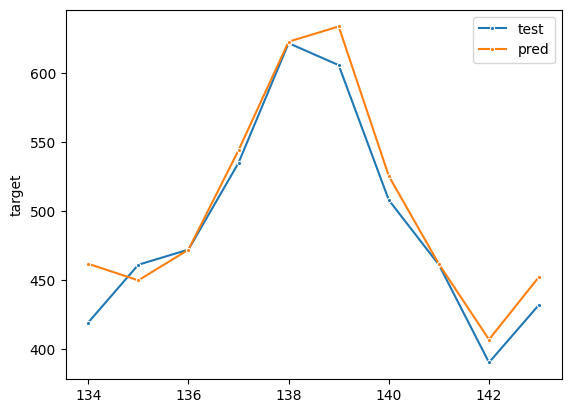

In [5]:
forecast = results.get_forecast(steps=10)
y_pred = forecast.predicted_mean # 各時点の期待値を予測とする

fig, ax = plt.subplots()
#sns.lineplot(df_train["target"], label="train", marker='.')
sns.lineplot(df_test["target"], label="test", marker='.')
sns.lineplot(y_pred, label="pred", marker='.')
plt.show()

In [6]:
display(forecast.predicted_mean) # 各時点の期待値
display(forecast.var_pred_mean) # 各時点の分散

134   461.72502
135   449.64672
136   471.94628
137   544.17055
138   623.04109
139   634.10196
140   525.44412
141   461.46805
142   406.66490
143   452.28110
Name: predicted_mean, dtype: float64

134    80.95502
135   112.60410
136   139.12466
137   161.34776
138   179.96976
139   195.57419
140   208.65003
141   219.60703
142   228.78852
143   236.48221
Name: var_pred_mean, dtype: float64

予測値の総和を求める
  - 作ったモデルでN時点先までを予測する行為を複数回シミュレーションし、シミュレーション結果から各時点までの総和の信頼区間を求める
  - SARIMAXのsimulateメソッドを使ってシミュレーションできそう(https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.simulate.html)


In [7]:
nsimulations = 10 # 何時点先まで予測をするか
repetitions = 10000 # シミュレーションを何回実行するか
anchor = len(df_train) # シミュレーションの開始時刻

simulated_obs = results.simulate(nsimulations=nsimulations, repetitions=repetitions, anchor=anchor)
simulated_obs # (予測時点数, シミュレーション回数)のシミュレーション結果

target                                                              \
         0         1         2         3         4         5         6      
134 459.35042 486.01303 469.75835 458.40823 476.82219 466.80365 457.51577   
135 453.85219 467.34261 438.76238 446.64665 451.31218 459.56985 438.24107   
136 457.95759 480.03957 464.70262 468.17409 463.49853 475.07213 475.05957   
137 545.46564 552.12171 545.28479 541.85744 535.94409 538.99672 542.39384   
138 611.21979 638.31303 617.64810 616.22361 621.80218 613.73923 627.78315   
139 640.60093 653.52534 614.63085 631.11150 631.45744 630.28269 635.18979   
140 536.85029 519.25963 496.00765 541.48988 532.81828 515.81164 520.18489   
141 474.68471 464.73642 442.27444 474.00944 460.51594 460.60072 473.36334   
142 428.16985 406.31307 380.33799 423.44308 413.70007 426.60396 412.79308   
143 466.47539 457.38898 436.38629 464.68428 468.68210 445.77789 449.39346   

                                   ...                                \
         7         8         9     ...      9990      9991      9992   
134 455.75961 471.01178 476.66163  ... 464.30037 466.39061 459.51453   
135 444.29622 462.87216 459.83907  ... 441.21493 461.95520 436.24668   
136 469.53054 494.74821 477.80902  ... 465.83798 486.97235 451.72024   
137 533.88255 552.77358 546.41846  ... 543.28962 541.29688 530.11106   
138 633.42537 622.06423 625.78513  ... 605.33784 620.63057 610.84273   
139 637.45707 634.64593 631.92075  ... 614.18014 643.12786 623.61101   
140 511.37835 506.49218 513.81326  ... 504.19845 515.34368 513.44615   
141 451.45044 446.09926 454.62810  ... 448.36723 463.79648 440.96347   
142 384.92538 387.71211 393.81703  ... 392.95672 415.32022 397.84788   
143 429.18304 450.81058 443.33007  ... 429.80345 457.78805 440.38379   

                                                                           
         9993      9994      9995      9996      9997      9998      9999  
134 455.71928 456.52567 451.26999 464.13821 468.45896 459.49456 480.56099  
135 437.34007 436.31849 450.38457 451.72914 467.65859 454.24607 453.40538  
136 460.41458 452.14981 469.31173 486.96816 468.84737 489.10741 467.96406  
137 537.33099 532.88508 532.83222 551.38030 552.65333 569.81986 559.06586  
138 613.56261 614.35475 614.97612 636.38121 634.61424 650.10013 637.49007  
139 635.95951 636.55814 639.63535 646.73092 648.85812 663.80803 635.73635  
140 505.28500 522.29225 528.78617 521.51174 557.45004 548.49803 525.80940  
141 447.67907 464.28663 470.38471 461.13416 483.33108 485.91051 455.13555  
142 375.70119 405.39349 422.97252 401.87335 432.82033 428.43574 405.96596  
143 431.76723 448.52062 477.06144 450.08454 464.60732 452.33291 445.53912  

[10 rows x 10000 columns]

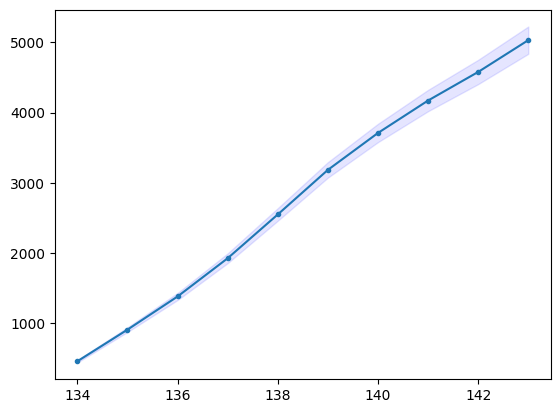

In [8]:
def simulation_of_confidence_intervals(simulated_obs):
    y, ci_upper, ci_lower = [], [], [] # 各時点の期待値、信頼区間の上限、信頼区間の下限

    for i in range(nsimulations):
        simulated_obs_part = simulated_obs.iloc[:i+1] # 時点iまでの予測値のシミュレーションを取り出す
        simulated_obs_part_mean = simulated_obs_part.sum(axis=0).mean() # 時点iまでの総和のシミュレーションの期待値を求める
        y.append(simulated_obs_part_mean)
        std_value = simulated_obs_part.sum(axis=0).std() # 時点iまでの総和のシミュレーションの標準偏差を求める
        ci_upper.append(simulated_obs_part_mean + 1.96*std_value) # 総和のシミュレーションの期待値と標準偏差から信頼区間を求める
        ci_lower.append(simulated_obs_part_mean - 1.96*std_value)
    return y, ci_upper, ci_lower


y, ci_upper, ci_lower = simulation_of_confidence_intervals(simulated_obs)
x = list(range(len(df_train), len(df_train)+nsimulations))
fig, ax = plt.subplots()
ax.plot(x, y, marker=".")
ax.fill_between(x, ci_upper, ci_lower, color='b', alpha=.1)
plt.show()